In [89]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import normalize
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel
from pythainlp.tokenize import word_tokenize

import re
import unicodedata
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce



part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp

In [90]:
# โหลดไฟล์ CSV (กรณีชื่อคอลัมน์ 'label')
df = pd.read_csv('news_dataset_truefakenews.csv')
# ถ้าชื่อคอลัมน์สะกดผิด
df = df.rename(columns={'lable':'label', 'autor':'author'})

In [ ]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'คลังความรู้': 'true',
    'ข่าวปลอม': 'fake',
    'อาชญากรออนไลน์': 'fake',
    'ข่าวบิดเบือน': 'fake',
    'ข่าวอื่นๆ': None  # ลบออกเลย
}

In [92]:
# 2) ทำความสะอาด label ลบอิโมจิ และแมปค่า 
# Normalization Function
ZW = ''.join(['\u200B','\u200C','\u200D','\uFEFF'])
def normalize_thai(s):
    if pd.isna(s): return None
    s = str(s).replace('\u00A0',' ').translate({ord(ch):None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['label'] = df['label'].apply(normalize_thai)
CANON = {'ข่าวจริง':'ข่าวจริง', 'ข่าวปลอม':'ข่าวปลอม'}
ALIASES = {'ข่าวจริิง':'ข่าวจริง', 'ข่่าวจริง':'ข่าวจริง', 'ข่่าวบิดเบือน':'ข่าวปลอม'} # เปลี่ยนบิดเบือนเป็นปลอมตามการแมปเดิม

df['label'] = df['label'].replace(ALIASES)
df = df[df['label'].isin(CANON.keys())].dropna(subset=['title','content']).reset_index(drop=True)



In [93]:
# สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
#df['label_binary'] = df['label'].map(label_map)

# ลบแถวที่เป็น None (ข่าวอื่นๆ)
#df = df.dropna(subset=['label_binary'])

# ถ้าต้องการ save เป็น CSV ใหม่
#df.to_csv('news_dataset_truefakenews.csv', index=False)

# ดูผลลัพธ์
print(df.head())

                  date                                         link  \
0  23/07/2568 09:00:20  https://www.antifakenewscenter.com/?p=74581   
1  23/07/2568 08:00:51  https://www.antifakenewscenter.com/?p=74577   
2  23/07/2568 07:00:51  https://www.antifakenewscenter.com/?p=74573   
3  23/07/2568 06:30:23  https://www.antifakenewscenter.com/?p=74569   
4  23/07/2568 03:30:03  https://www.antifakenewscenter.com/?p=74561   

                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยส

In [94]:
# 3) ตัดคำ (ไม่เก็บช่องว่าง)
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)

In [95]:
# 4) โหลดโมเดลภาษาไทย + จัด device
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

model = AutoModel.from_pretrained(model_name) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device).eval()


Dataset Size: 818 | ข่าวจริง: 233, ข่าวปลอม: 585


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

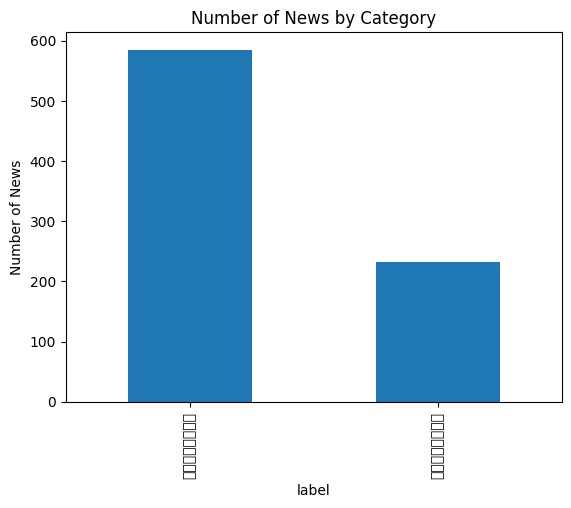

In [96]:
num_true = (df['label'] == 'ข่าวจริง').sum() 
num_fake = (df['label'] == 'ข่าวปลอม').sum() 
print(f"Dataset Size: {len(df)} | ข่าวจริง: {num_true}, ข่าวปลอม: {num_fake}")


#กราฟ
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar') 
plt.title('Number of News by Category') 
plt.ylabel('Number of News') 
plt.show()

In [97]:
# Show sample of tokenized data
print("Sample of tokenized titles:")
print(df[['title', 'title_tokens']].head())
print("\nSample of tokenized content:")
print(df[['content', 'content_tokens']].head())

# Print token statistics
print("\nToken statistics:")
print(f"Average tokens in titles: {df['title_tokens'].str.len().mean():.2f}")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

Sample of tokenized titles:
                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                        title_tokens  
0  [OR, ชวน, ร่วม, เป็น, เจ้าของกิจการ, ลงทุน, หุ...  
1  [กระทรวงยุติธรรม, เปิด, เพจ, เฟซบุ๊ก, ชื่อ, Te...  
2  [หุ้น, OKJ, เปิด, เทรด, วัน, แรก, ราคา, เปิด, ...  
3  [กรุงไทย, เปิด, ให้, จอง, สิทธิ์, ยืม, เงิน, 1...  
4  [ก.ล.ต., เปิด, เว็บไซต์, ให้, ผู้ลงทุน, สะสม, ...  

Sample of tokenized content:
                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยสินเชื่อ บนบัญชี TikTok ชื่อ ktb.thai ..

In [98]:
# -------------------------------------------
# 1) ฟังก์ชันสร้าง BERT Embedding 
# -------------------------------------------
@torch.no_grad()
# 💡 ใช้ mean pool เป็นค่าตั้งต้น เนื่องจากเหมาะกับการทำ Sentence/Document Embedding
def get_bert_embedding_from_tokens(tokens, max_length=128, use_mean_pool=True): 
    # ใช้ Global variable: tokenizer, model, device
    text = ' '.join(tokens)
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    ).to(device)
    outputs = model(**inputs)  # last_hidden_state: [1, L, H]

    if use_mean_pool:
        attn = inputs['attention_mask'].unsqueeze(-1)  # [1, L, 1]
        summed = (outputs.last_hidden_state * attn).sum(dim=1)
        denom = attn.sum(dim=1).clamp(min=1)
        emb = (summed / denom).squeeze(0).cpu().numpy()
    else:
        emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()  # [CLS]
    return emb

In [99]:
# -------------------------------------------
# 2) สร้าง Embeddings สำหรับทุกแถวใน DataFrame (ใช้ Mean Pool)
# -------------------------------------------
print("\n🧠 Creating BERT Embeddings for Title and Content...")

# สร้าง embedding จากคอลัมน์ title_tokens
# 💡 ใช้ Mean Pool
title_emb = np.vstack([
    get_bert_embedding_from_tokens(toks, use_mean_pool=True)
    for toks in df['title_tokens']
])

# สร้าง embedding จากคอลัมน์ content_tokens
# 💡 ใช้ Mean Pool
content_emb = np.vstack([
    get_bert_embedding_from_tokens(toks, use_mean_pool=True)
    for toks in df['content_tokens']
])

print(f"✅ Title embeddings shape: {title_emb.shape}")
print(f"✅ Content embeddings shape: {content_emb.shape}")


# ส่วน Concatenate (ที่ทำซ้ำ)
print("\nConcatenating BERT Embeddings...")
# ใช้ Title และ Content Embedding ที่สร้างไว้แล้ว
x_np = np.concatenate([title_emb, content_emb], axis=1) # รวม Title และ Content Embeddings (N x 1536)

x_np = normalize(x_np, norm='l2', axis=1) # Normalize Features
print(f"Feature Vector (x_np) shape: {x_np.shape}")

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🧠 Creating BERT Embeddings for Title and Content...
✅ Title embeddings shape: (818, 768)
✅ Content embeddings shape: (818, 768)

Concatenating BERT Embeddings...
Feature Vector (x_np) shape: (818, 1536)


หน้าตาเป็นไง ใช้สูตรอะไร

In [100]:
import pandas as pd
pd.DataFrame(x_np).head()

print(x_np.shape)   # ดูขนาด เช่น (จำนวนเอกสาร, ขนาดเวกเตอร์)
print(x_np[0])      # ดู embedding ของตัวอย่างแรก


(818, 1536)
[ 0.00712323 -0.05139524  0.00802879 ... -0.0102368   0.03449164
  0.0053923 ]


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

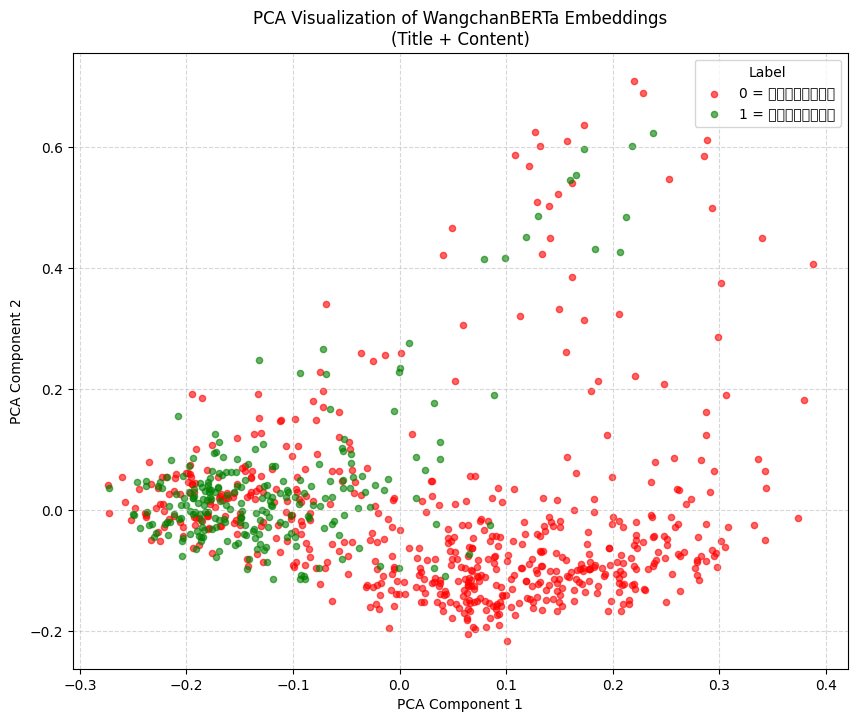

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 💡 สำคัญ: ใช้ y_np ที่เป็น Label ตัวเลข (0 หรือ 1) 
#           ซึ่งถูกสร้างไว้ในขั้นตอนการทำ GCN Graph
# --------------------------------------------------------
labels_numeric = y_np # y_np คือ Label ที่ถูก map เป็น 0, 1 แล้ว (0=ข่าวปลอม, 1=ข่าวจริง)
id2label = {i: c for c,i in label2id.items()} # เพื่อให้รู้ว่า 0 คืออะไร 1 คืออะไร

# ทำ PCA เหมือนเดิม
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_np)

# แยกจุดตาม class (โดยใช้ตัวเลข)
# เราสมมติว่า 0 คือ 'ข่าวปลอม' และ 1 คือ 'ข่าวจริง' ตาม label2id ที่เคยสร้างไว้:
# label2id = {'ข่าวปลอม': 0, 'ข่าวจริง': 1}
fake_mask = labels_numeric == 1
fact_mask = labels_numeric == 0

# พล็อต scatter พร้อมสี
plt.figure(figsize=(10, 8))

# พล็อต 'ข่าวปลอม' (Label 1)
plt.scatter(x_2d[fake_mask, 0], x_2d[fake_mask, 1], 
            color='red', alpha=0.6, s=20, 
            label=f'0 = {id2label.get(0, "N/A")}')

# พล็อต 'ข่าวจริง' (Label 0)
plt.scatter(x_2d[fact_mask, 0], x_2d[fact_mask, 1], 
            color='green', alpha=0.6, s=20, 
            label=f'1 = {id2label.get(1, "N/A")}')

plt.title("PCA Visualization of WangchanBERTa Embeddings\n(Title + Content)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Label")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

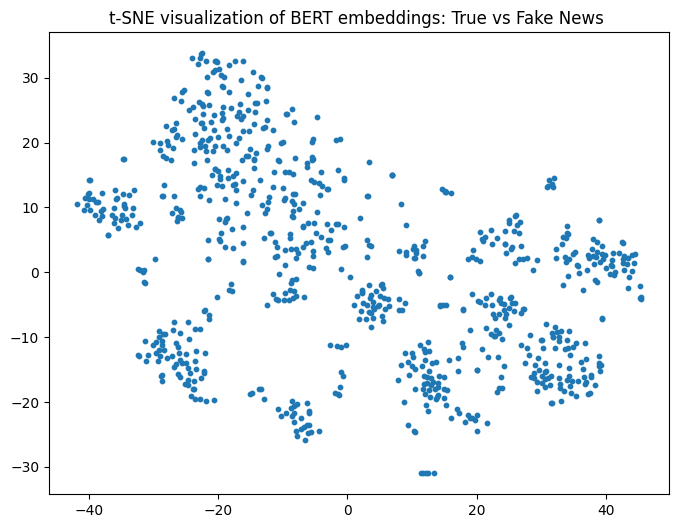

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#ด้านความหมาย

tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_np)

plt.figure(figsize=(8,6))
plt.scatter(x_2d[:,0], x_2d[:,1], s=10)
plt.title("t-SNE visualization of BERT embeddings: True vs Fake News ")
plt.show()


เสร็จ embedding //ทำไมจุดเป็นแบบนี้

In [151]:
# --- 3. การสร้าง kNN-Graph และ Data Object ---

# แปลง labels -> ตัวเลข
classes = sorted(df['label'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['label'].map(label2id).values
print(f"Classes: {label2id}")

Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


In [152]:
print(df['label'].unique())


['ข่าวปลอม' 'ข่าวจริง']


In [104]:
N = x_np.shape[0]
k = min(8, max(3, int(np.round(np.log2(max(N, 2)))))) # k=8 (ตามที่วิเคราะห์)

print(f"Building kNN Graph with k={k}...")
nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(x_np)
dist, idx = nbrs.kneighbors(x_np)

# สร้าง undirected edges
src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1)

edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)
edge_index, edge_weight = coalesce(edge_index, edge_weight, reduce='mean')




Building kNN Graph with k=8...


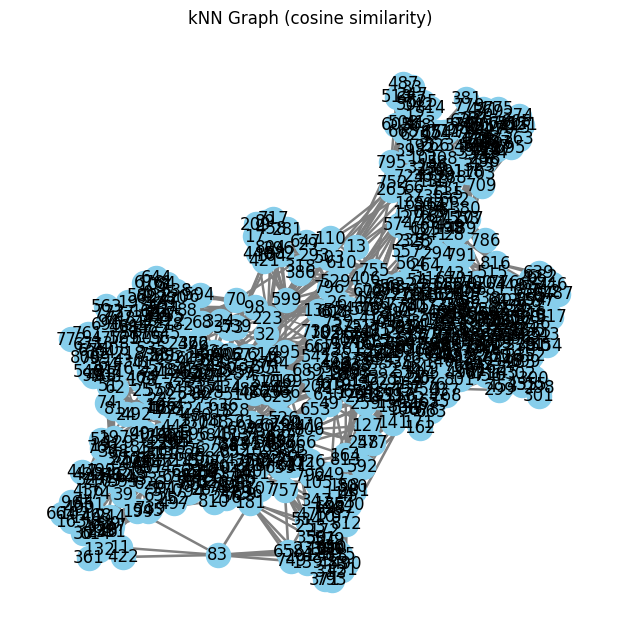

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

# สร้างกราฟจาก edge_index_np
G = nx.Graph()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# ถ้าอยากใช้ weight เป็นความหนาของเส้น
weights = edge_weight_np

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout สวยงามอัตโนมัติ
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights * 2)
plt.title("kNN Graph (cosine similarity)")
plt.show()


In [106]:
# 9) สร้าง Data + split
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
data.edge_weight = edge_weight

# Split data 70/15/15
idx_all = np.arange(N)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_np, random_state=42)
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_np[idx_train], random_state=42) # 0.1765 * 0.85 = 0.15

train_mask = torch.zeros(N, dtype=torch.bool); train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool); val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool); test_mask[idx_test] = True
data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask


In [107]:
print(y_np)  # แสดงค่าทุกอัน
print(np.unique(y_np, return_counts=True))  

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 

In [137]:
# 10) สร้าง GCN model  4เลเยอร์
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNNet(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) with 4 layers.
    Uses WangchanBERTa embeddings as node features (input_features).
    """
    def __init__(self, num_node_features, num_classes, hidden_channels=128, dropout_rate=0.5):
        super().__init__()
        
        # 1. Input Layer: Feature Size -> Hidden Size
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        
        # 2. Hidden Layer 2: Hidden Size -> Hidden Size
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # 3. Hidden Layer 3: Hidden Size -> Hidden Size
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # 4. Output Layer: Hidden Size -> Number of Classes
        self.conv4 = GCNConv(hidden_channels, num_classes)
        
        self.dropout_rate = dropout_rate

    def forward(self, data):
        # Unpack data
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        
        # Layer 1: GCN -> ReLU -> Dropout
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 2: GCN -> ReLU -> Dropout
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 3: GCN -> ReLU -> Dropout
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 4: Output Layer (no ReLU/Dropout)
        x = self.conv4(x, edge_index, edge_weight)
        
        # F.log_softmax สำหรับใช้กับ F.cross_entropy
        return F.log_softmax(x, dim=1)

In [140]:
# --- 5. GCN Training Loop ---

# Setup
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(classes) 
LR_RATE = 1e-3
WEIGHT_DECAY = 5e-4
PATIENCE_LIMIT = 30 
SCHEDULER_PATIENCE = 15

model_gnn = GCNNet(
    num_node_features=NUM_NODE_FEATURES, 
    hidden_channels=128, 
    num_classes=NUM_CLASSES, 
    dropout_rate=0.5
).to(device)
data = data.to(device)

# Class Weight (จัดการ Imbalance)
cls_w = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_np)
cls_w = torch.tensor(cls_w, dtype=torch.float, device=device)

# Optimizer & Scheduler (แก้ไข TypeError: ลบ verbose)
opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE) 

# Evaluation Function
def evaluate(logits, mask, data):
    y_true = data.y[mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    return acc, f1m

# Training Loop
num_epochs = 500
best_val_f1, best_state, best_epoch = -1, None, 0
patience_counter = 0

print("\n--- Starting GCN Training ---")
for epoch in range(1, num_epochs + 1):
    model_gnn.train()
    opt.zero_grad()
    out = model_gnn(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    loss.backward()
    opt.step()

    model_gnn.eval()
    with torch.no_grad():
        val_acc, val_f1 = evaluate(out, data.val_mask, data)

    # Early Stopping & Best Model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k,v in model_gnn.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    scheduler.step(val_f1)

    if epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val F1: {val_f1:.4f} | LR: {opt.param_groups[0]['lr']:.1e} | Patience: {patience_counter}")
    
    if patience_counter >= PATIENCE_LIMIT:
        print(f"\n*** Early stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} found at epoch {best_epoch}. ***")
        break


--- Starting GCN Training ---
Epoch 050 | Loss: 0.3727 | Val F1: 0.8582 | LR: 1.0e-03 | Patience: 2

*** Early stopping at epoch 81. Best F1: 0.8988 found at epoch 51. ***


In [110]:
# load best model
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device) for k,v in best_state.items()})

In [111]:
# --- 7. Inductive Prediction Function (สำหรับข่าวใหม่) ---

def predict_news(title=None, content=None,
                 # ⬅️ แก้ไข: ลบ model_bert (โค้ดเดิมใช้ Global model อยู่แล้ว)
                 tokenizer=tokenizer, 
                 model_gnn=model_gnn,
                 df=df, x_np=x_np, label2id=label2id, 
                 device=device, topn=k): 
    
    assert title and content, "ต้องใส่ทั้ง title และ content สำหรับการทำนาย"
    
    # 1. ตัดคำ
    def thai_token_list(text):
        if text is None or len(str(text).strip()) == 0: return []
        return word_tokenize(str(text), engine='newmm', keep_whitespace=False)
    title_tokens = thai_token_list(title)
    content_tokens = thai_token_list(content)
    
    # 2. สร้าง embedding และ Concatenate
    # ⬅️ แก้ไข: ลบ arguments ที่เกินมาในการเรียกใช้ get_bert_embedding_from_tokens
    title_emb = get_bert_embedding_from_tokens(title_tokens, use_mean_pool=True)
    content_emb = get_bert_embedding_from_tokens(content_tokens, use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]
    # ... (โค้ดส่วนที่เหลือไม่มีการเปลี่ยนแปลง)

In [112]:
# --- 7. Inductive Prediction Function (สำหรับข่าวใหม่) ---

def predict_news(title=None, content=None,
                 tokenizer=tokenizer, 
                 model_gnn=model_gnn,
                 df=df, x_np=x_np, label2id=label2id, 
                 device=device, topn=k): 
    
    assert title and content, "ต้องใส่ทั้ง title และ content สำหรับการทำนาย"
    
    # 1. ตัดคำ
    def thai_token_list(text):
        if text is None or len(str(text).strip()) == 0: return []
        return word_tokenize(str(text), engine='newmm', keep_whitespace=False)
    title_tokens = thai_token_list(title)
    content_tokens = thai_token_list(content)
    
    # 2. สร้าง embedding และ Concatenate
    # 💡 ปรับปรุง: ใช้ use_mean_pool=True และใช้ np.concatenate(..., axis=1) 
    #    เพื่อให้ Feature Vector มีขนาด (1, 1536) เหมือนกับ x_np
    
    title_emb = get_bert_embedding_from_tokens(title_tokens, use_mean_pool=True) # shape (768,)
    content_emb = get_bert_embedding_from_tokens(content_tokens, use_mean_pool=True) # shape (768,)
    
    # 🚨 แก้ไข: เปลี่ยนการรวมจาก axis=0 เป็น axis=1 (หรือใช้ hstack) เพื่อให้ได้ (1536,)
    emb = np.concatenate([title_emb, content_emb], axis=0) # shape (1536,)
    
    # Normalize (ไม่ต้องใช้ .reshape(1, -1) แล้ว เพราะ normalize รองรับ (D,) vector)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]
    
    # 3. สร้าง mini-graph (Inductive)
    N_train = x_np.shape[0]
    nbrs = NearestNeighbors(n_neighbors=topn, metric='cosine').fit(x_np)
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1)) # ต้อง reshape (1, D)
    
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]]) # Node 0 คือข่าวใหม่, Node 1..k คือเพื่อนบ้าน
    
    # Edges: Node 0 (ข่าวใหม่) <-> Node 1..k (เพื่อนบ้าน)
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1,topn+1)]),
        np.stack([np.arange(1,topn+1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1-dists[0], 1-dists[0]])
    
    # 4. ลง GCN ทายผล
    from torch_geometric.data import Data
    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)
    
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = logits[0].argmax(dim=-1).item()
        id2label = {i: c for c,i in label2id.items()}
        label_pred = id2label[pred_id]
        
    return {'label': label_pred, 'probability': probas[pred_id], 'proba_all': probas, 'id2label': id2label}

# --- 8. ตัวอย่างการใช้งานจริง ---

print("\n--- DEMO: Test Inductive Prediction ---")
# ข่าวจริงตัวอย่าง
title_real = "นายกรัฐมนตรีประกาศเพิ่มค่าแรงขั้นต่ำทั่วประเทศ เริ่มต้นปีหน้า"
content_real = "กระทรวงแรงงานยืนยันว่าการปรับขึ้นค่าแรงขั้นต่ำมีผลบังคับใช้ตั้งแต่วันที่ 1 มกราคม 2569 ตามมติคณะรัฐมนตรี เพื่อยกระดับความเป็นอยู่ของแรงงาน"

# ข่าวปลอมตัวอย่าง (สมมติ)
title_fake = "ด่วน! รัฐบาลออกกฎหมายบังคับให้ประชาชนทุกคนต้องฉีดวัคซีนป้องกันหวัดสายพันธุ์ใหม่"
content_fake = "ข่าวลือที่แพร่หลายในโซเชียลมีเดียระบุว่า หากไม่ฉีดวัคซีนตามที่รัฐบาลกำหนด จะถูกปรับเป็นเงิน 100,000 บาท ซึ่งหน่วยงานสาธารณสุขได้ออกมาปฏิเสธและชี้แจงแล้ว"

# ทายข่าวปลอม
result_fake = predict_news(title=title_fake, content=content_fake)
print(f"\n[ข่าวปลอมตัวอย่าง]\nทำนาย: {result_fake['label']} | ความมั่นใจ: {result_fake['probability']:.3f}")
print(f"Probas: {result_fake['id2label'][0]}: {result_fake['proba_all'][0]:.3f}, {result_fake['id2label'][1]}: {result_fake['proba_all'][1]:.3f}")

# ทายข่าวจริง
result_real = predict_news(title=title_real, content=content_real)
print(f"\n[ข่าวจริงตัวอย่าง]\nทำนาย: {result_real['label']} | ความมั่นใจ: {result_real['probability']:.3f}")
print(f"Probas: {result_real['id2label'][0]}: {result_real['proba_all'][0]:.3f}, {result_real['id2label'][1]}: {result_real['proba_all'][1]:.3f}")


--- DEMO: Test Inductive Prediction ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[ข่าวปลอมตัวอย่าง]
ทำนาย: ข่าวจริง | ความมั่นใจ: 0.995
Probas: ข่าวจริง: 0.995, ข่าวปลอม: 0.005


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[ข่าวจริงตัวอย่าง]
ทำนาย: ข่าวจริง | ความมั่นใจ: 1.000
Probas: ข่าวจริง: 1.000, ข่าวปลอม: 0.000


In [141]:
# ------------------- รับ input จากผู้ใช้ -------------------
title = input("กรอกหัวข้อข่าว (ถ้าไม่มี ให้กด Enter):\n")
content = input("กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน):\n")

# เช็คว่า:
if not title and not content:
    print("กรุณาใส่ title หรือเนื้อหาข่าว อย่างน้อย 1 อย่าง")
else:
    result = predict_news(
        title=title,
        content=content,
        tokenizer=tokenizer,
        # ⬅️ แก้ไข: ลบ model_bert=model ออกไป
        model_gnn=model_gnn,
        df=df, x_np=x_np, label2id=label2id, device=device, topn=8
    )
    print("\nผลการตรวจสอบข่าว:")
    print(f">>> ข่าวนี้น่าจะเป็น :  {result['label']}  (ความมั่นใจ = {result['probability']:.3f})")
    print("รายละเอียด probability (แต่ละ class):จริง ซ้าย/ปลอม ขวา", result['proba_all'])

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



ผลการตรวจสอบข่าว:
>>> ข่าวนี้น่าจะเป็น :  ข่าวปลอม  (ความมั่นใจ = 0.982)
รายละเอียด probability (แต่ละ class):จริง ซ้าย/ปลอม ขวา [0.01766097 0.9823391 ]


node_pos: 30, color_map: 30, G.nodes: 30


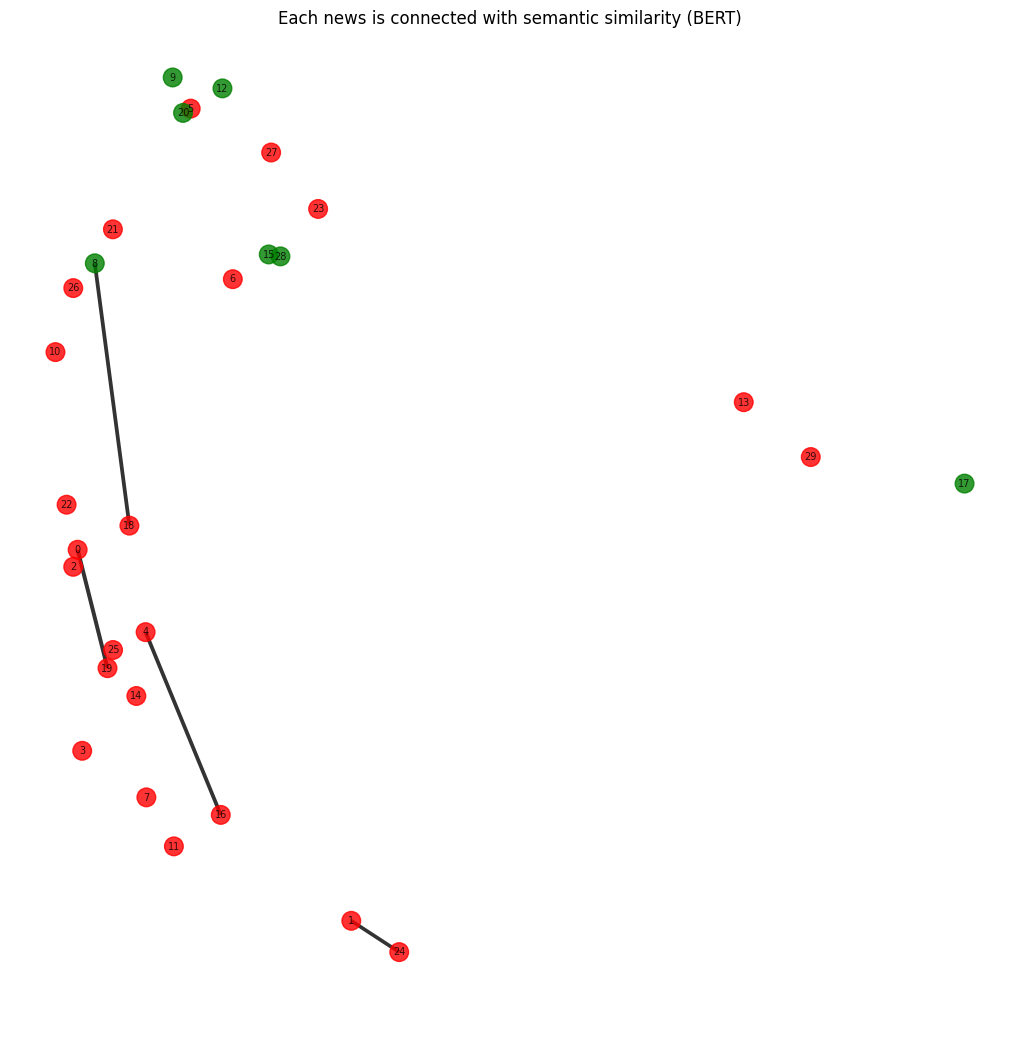

In [114]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# สมมติ plot 30 node แรก
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # เพื่อกัน node ที่ไม่มี edge หายไป
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='ข่าวปลอม' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

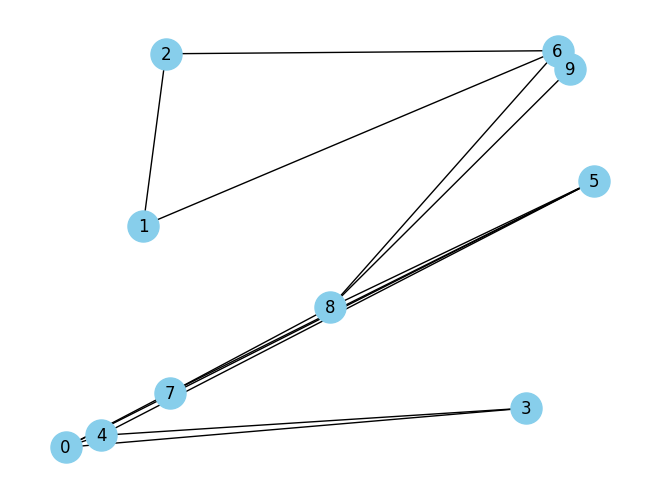

In [115]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


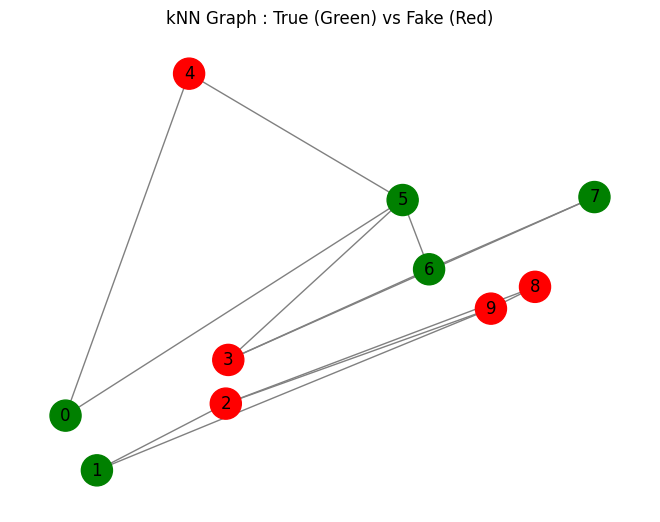

In [116]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


In [117]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


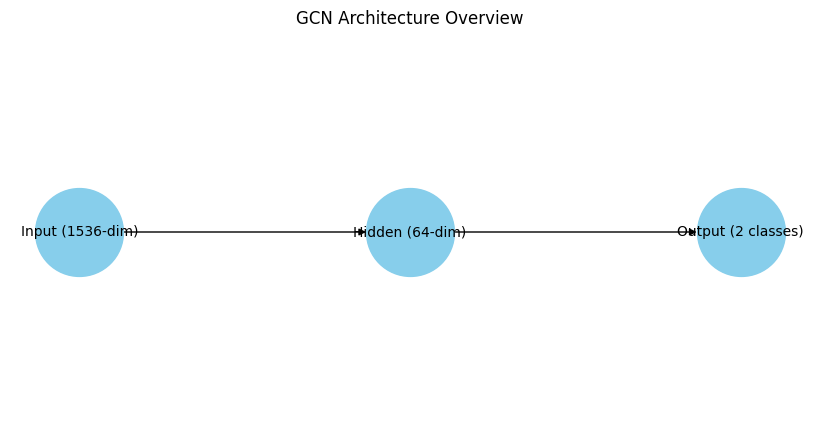

In [118]:
# ----- วาดโครงสร้าง GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# เพิ่มโหนด
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# เพิ่ม edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# วาด
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


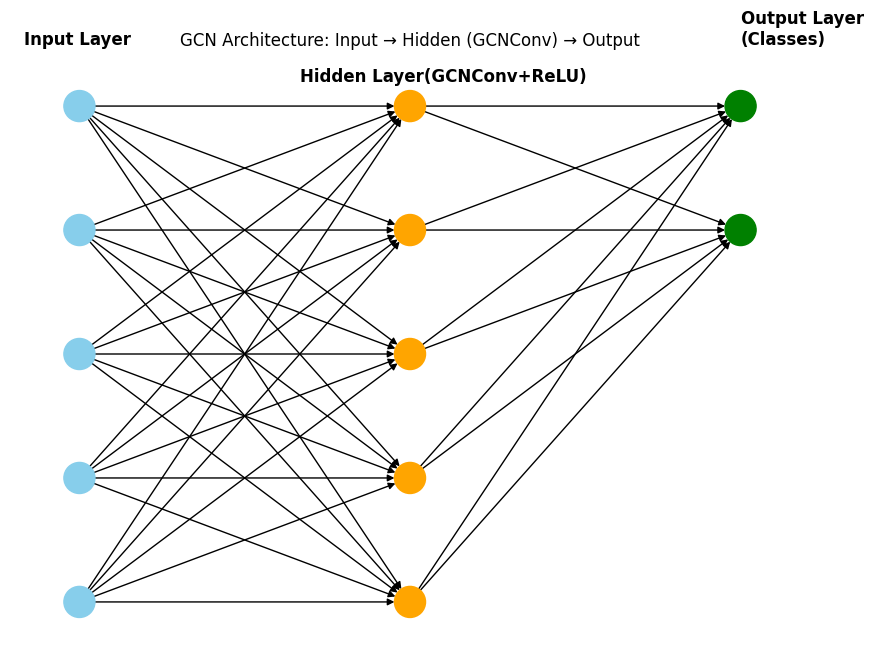

In [119]:
import matplotlib.pyplot as plt
import networkx as nx

# สร้างโครงสร้าง GCN: Input Layer → Hidden Layer → Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ตัวอย่างมี 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# เพิ่ม node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# เชื่อม edge แบบ fully-connected ระหว่างแต่ละชั้น
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# จัดตำแหน่ง node แยกเป็น layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map สี
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# วาดกราฟ
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# เพิ่ม label ชื่อ layer (ใช้ตำแหน่งเฉพาะ)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input → Hidden (GCNConv) → Output")
plt.axis("off")
plt.show()



BERT MLP

In [153]:
# ==========================================================
# 5. MLP Model (BERT Baseline) Definition และ Training
# ==========================================================

class MLPClassifier(nn.Module):
    """Multi-Layer Perceptron (MLP) สำหรับ BERT Baseline"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.layer3(x)
        return F.log_softmax(x, dim=1)
    import torch.nn.functional as F
from torch import nn

mlp = nn.Sequential(
    nn.Linear(x_np.shape[1], 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2)
)


In [154]:
# Setup Baseline Model
NUM_FEATURES = x_np.shape[1]
NUM_CLASSES = len(classes)
LR_RATE_MLP = 1e-3

model_mlp = MLPClassifier(
    input_dim=NUM_FEATURES,
    hidden_dim=128,
    output_dim=NUM_CLASSES
).to(device)

# เตรียมข้อมูลสำหรับ MLP (ใช้ Index เดิม)
X_train, Y_train = x_np[idx_train], y_np[idx_train]
X_test, Y_test = x_np[idx_test], y_np[idx_test]

X_train_t = torch.tensor(X_train, dtype=torch.float, device=device)
Y_train_t = torch.tensor(Y_train, dtype=torch.long, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=device)
# Y_test_t = torch.tensor(Y_test, dtype=torch.long, device=device) # ไม่จำเป็นต้องใช้ในการทดสอบ

# Class Weight
cls_w_mlp = torch.tensor(
    compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=Y_train), 
    dtype=torch.float, 
    device=device
)

# Optimizer
opt_mlp = torch.optim.Adam(model_mlp.parameters(), lr=LR_RATE_MLP, weight_decay=5e-4)

# Training Loop สำหรับ MLP
print("\n--- Starting BERT Embedding Baseline Training (MLP) ---")
for epoch in range(1, 101): 
    model_mlp.train()
    opt_mlp.zero_grad()
    
    out = model_mlp(X_train_t)
    loss = F.cross_entropy(out, Y_train_t, weight=cls_w_mlp)
    
    loss.backward()
    opt_mlp.step()


--- Starting BERT Embedding Baseline Training (MLP) ---


In [157]:
# ----------------------------------------------------------------
# 5.1 คำนวณและจัดเก็บ Metrics ของ MLP Baseline (Test Set)
# ----------------------------------------------------------------

def evaluate_simple(logits, y_true):
    y_pred = logits.argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    f1_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    return acc, f1m, f1_class

model_mlp.eval()
with torch.no_grad():
    out_test_mlp = model_mlp(X_test_t)
    test_acc_mlp, test_f1_mlp, f1_class_mlp = evaluate_simple(out_test_mlp, Y_test)

results_mlp = {
    'Accuracy': test_acc_mlp,
    'F1-Macro': test_f1_mlp,
    'F1 (ข่าวปลอม)': f1_class_mlp[0] if NUM_CLASSES > 0 else 0,
    'F1 (ข่าวจริง)': f1_class_mlp[1] if NUM_CLASSES > 1 else 0
}
print(f"✅ MLP Baseline Test F1-Macro: {test_f1_mlp:.4f}")

✅ MLP Baseline Test F1-Macro: 0.8561


In [166]:
# ----------------------------------------------------------------
# 3. Inductive Prediction Function (BERT ธรรมดา)
# ----------------------------------------------------------------

# แปลง label2id → inv_label_map
inv_label_map = {v: k for k, v in label2id.items()}

def predict_news_bert_only(title=None, content=None, model_mlp=model_mlp, label2id=label2id, device=device):
    assert title and content, "ต้องใส่ทั้ง title และ content สำหรับการทำนาย"

    # 1. ตัดคำ
    def thai_token_list(text):
        if text is None or len(str(text).strip()) == 0: return []
        return word_tokenize(str(text), engine='newmm', keep_whitespace=False)

    title_tokens = thai_token_list(title)
    content_tokens = thai_token_list(content)

    # 2. สร้าง embedding
    title_emb = get_bert_embedding_from_tokens(title_tokens, use_mean_pool=True)
    content_emb = get_bert_embedding_from_tokens(content_tokens, use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')

    # 3. ลง MLP ทายผล
    x_tensor = torch.tensor(emb, dtype=torch.float, device=device)
    model_mlp.eval()
    with torch.no_grad():
        logits = model_mlp(x_tensor)
        prob_all = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        pred_label = logits.argmax(dim=1).item()
        prob_max = prob_all[pred_label]

    # 4. Return dict พร้อม label แปลงตัวเลข → ชื่อคลาส
    inv_label_map = {v: k for k, v in label2id.items()}  # ใส่ตรงนี้เลย
    return {
        'label': inv_label_map[int(pred_label)],
        'probability': float(prob_max),
        'proba_all': prob_all
    }

    
    # MLP ได้ถูกฝึกถึง Epoch สุดท้ายแล้ว
model_mlp.eval()
with torch.no_grad():
    # 1.1 คำนวณ Logits บน Test Set
    out_test_mlp = model_mlp(X_test_t)
    
    # 1.2 เตรียม Data Object จำลองสำหรับ evaluate function (เพื่อใช้ฟังก์ชันเดิม)
    # y_np[idx_test] คือ label จริงของ Test Set
    data_test_mlp = Data(x=X_test_t, y=torch.tensor(Y_test, dtype=torch.long, device=device))
    test_mask_mlp = torch.ones(len(Y_test), dtype=torch.bool, device=device)

    # 1.3 ประเมินผล
    test_acc_mlp, test_f1_mlp = evaluate(out_test_mlp, test_mask_mlp, data_test_mlp)

    # 1.4 คำนวณ Class-Specific F1 (F1-score สำหรับแต่ละคลาส)
    y_true_mlp = data_test_mlp.y[test_mask_mlp].cpu().numpy()
    y_pred_mlp = out_test_mlp[test_mask_mlp].argmax(dim=1).cpu().numpy()
    
    # [F1_Class 0 (ข่าวปลอม), F1_Class 1 (ข่าวจริง)] - อ้างอิงตาม label2id = {'ข่าวปลอม': 0, 'ข่าวจริง': 1}
    f1_class_mlp = f1_score(y_true_mlp, y_pred_mlp, average=None, zero_division=0) 

# จัดเก็บผลลัพธ์ MLP ใน Dictionary
results_mlp = {
    'Accuracy': test_acc_mlp,
    'F1-Macro': test_f1_mlp,
    'F1 (ข่าวปลอม)': f1_class_mlp[0] if NUM_CLASSES > 0 else 0,
    'F1 (ข่าวจริง)': f1_class_mlp[1] if NUM_CLASSES > 1 else 0
}

print("\n✅ Metrics (BERT MLP Baseline) Collected.")


✅ Metrics (BERT MLP Baseline) Collected.


In [169]:
# --- 6. Final Evaluation on Test Set ---

# ... (โค้ด GCN evaluation เดิม)

model_gnn.load_state_dict(best_state)
model_gnn.eval()
with torch.no_grad():
    final_out_gcn = model_gnn(data) # ใช้ชื่อตัวแปรที่ชัดเจน
    test_acc_gcn, test_f1_gcn = evaluate(final_out_gcn, data.test_mask, data)
    
    # คำนวณ Class-Specific F1 สำหรับ GCN
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()
    f1_class_gcn = f1_score(y_true_gcn, y_pred_gcn, average=None, zero_division=0)
    
    # จัดเก็บผลลัพธ์ GCN
    results_gcn = {
        'Accuracy': test_acc_gcn,
        'F1-Macro': test_f1_gcn,
        'F1 (ข่าวปลอม)': f1_class_gcn[0] if NUM_CLASSES > 0 else 0,
        'F1 (ข่าวจริง)': f1_class_gcn[1] if NUM_CLASSES > 1 else 0
    }
    
    print("-" * 50)
    print(f"Training Complete. Best val F1: {best_val_f1:.4f} found at epoch {best_epoch}")
    print(f"Test Set Results (GCN): Accuracy: {test_acc_gcn:.4f}, F1-Macro: {test_f1_gcn:.4f}")
# ... (โค้ด load best model เดิม)

--------------------------------------------------
Training Complete. Best val F1: 0.8988 found at epoch 51
Test Set Results (GCN): Accuracy: 0.8618, F1-Macro: 0.8393


In [170]:
# ==========================================================
# 8. สรุปผลลัพธ์และการเปรียบเทียบ (Final Comparison)
# ==========================================================

# ----------------------------------------------------------------
# 8.1 สรุปตารางเปรียบเทียบ Metrics
# ----------------------------------------------------------------
print("\n" + "=" * 70)
print("                       📊 FINAL MODEL COMPARISON (TEST SET) 📊")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Macro', 'F1 (ข่าวปลอม)', 'F1 (ข่าวจริง)'],
    'BERT (MLP)': [results_mlp['Accuracy'], results_mlp['F1-Macro'], results_mlp['F1 (ข่าวปลอม)'], results_mlp['F1 (ข่าวจริง)']],
    'GCN + BERT': [results_gcn['Accuracy'], results_gcn['F1-Macro'], results_gcn['F1 (ข่าวปลอม)'], results_gcn['F1 (ข่าวจริง)']]
}).set_index('Metric')

comparison_df = comparison_df.round(4)  # ถ้าเป็นตัวเลข
# หรือถ้าอยากได้ string format
comparison_df = comparison_df.apply(lambda col: col.map(lambda x: f'{x:.4f}'))


print(comparison_df.to_markdown())

print("=" * 70)

# ----------------------------------------------------------------
# 8.2 สรุปผลการทำนายตัวอย่าง (Inference Comparison)
# ----------------------------------------------------------------

print("\n\n--- 🔎 Inference Probability Comparison (ตัวอย่าง) ---")

# กำหนดตัวอย่างข่าว
title_real = "นายกรัฐมนตรีประกาศเพิ่มค่าแรงขั้นต่ำทั่วประเทศ เริ่มต้นปีหน้า"
content_real = "กระทรวงแรงงานยืนยันว่าการปรับขึ้นค่าแรงขั้นต่ำมีผลบังคับใช้ตั้งแต่วันที่ 1 มกราคม 2569 ตามมติคณะรัฐมนตรี เพื่อยกระดับความเป็นอยู่ของแรงงาน"
title_fake = "ด่วน! รัฐบาลออกกฎหมายบังคับให้ประชาชนทุกคนต้องฉีดวัคซีนป้องกันหวัดสายพันธุ์ใหม่"
content_fake = "ข่าวลือที่แพร่หลายในโซเชียลมีเดียระบุว่า หากไม่ฉีดวัคซีนตามที่รัฐบาลกำหนด จะถูกปรับเป็นเงิน 100,000 บาท ซึ่งหน่วยงานสาธารณสุขได้ออกมาปฏิเสธและชี้แจงแล้ว"

# ทำนาย
result_fake = predict_news(title=title_fake, content=content_fake)
result_real = predict_news(title=title_real, content=content_real)
result_fake_bert = predict_news_bert_only(title=title_fake, content=content_fake)
result_real_bert = predict_news_bert_only(title=title_real, content=content_real)

# Safe Print Function

def safe_print_value(result, key, is_probability=False, index=None):
    if result and key in result:
        value = result[key]
        if is_probability:
            # สำหรับ 'probability'
            return f"{value:.4f}"
        
        elif index is not None and key == 'proba_all' and index < len(value):
            # สำหรับ proba_all[0] หรือ proba_all[1]
            return f"{value[index]:.4f}"
        
        # สำหรับ 'label'
        return str(value) 

    # กรณีที่ result เป็น None หรือ Key ไม่มีอยู่
    return "N/A"
print("-" * 70)
print("ข่าวปลอมตัวอย่าง (Fake News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawPlom (0)':<18} |")
print("-" * 70)

# ข่าวปลอม (Fake) - GCN
# ใช้ฟังก์ชันใหม่ในการจัดรูปแบบ
label_gcn_f = safe_print_value(result_fake, 'label')
prob_gcn_f = safe_print_value(result_fake, 'probability', is_probability=True)
proba_all_gcn_f = safe_print_value(result_fake, 'proba_all', index=0)

print(f"| {'GCN + BERT':<12} | {label_gcn_f:<10} | {prob_gcn_f:<18} | {proba_all_gcn_f:<18} |")

# ข่าวปลอม (Fake) - BERT (MLP)
label_bert_f = safe_print_value(result_fake_bert, 'label')
prob_bert_f = safe_print_value(result_fake_bert, 'probability', is_probability=True)
proba_all_bert_f = safe_print_value(result_fake_bert, 'proba_all', index=0)

print(f"| {'BERT (MLP)':<12} | {label_bert_f:<10} | {prob_bert_f:<18} | {proba_all_bert_f:<18} |")
print("-" * 70)


                       📊 FINAL MODEL COMPARISON (TEST SET) 📊
| Metric       |   BERT (MLP) |   GCN + BERT |
|:-------------|-------------:|-------------:|
| Accuracy     |       0.878  |       0.8618 |
| F1-Macro     |       0.8561 |       0.8393 |
| F1 (ข่าวปลอม) |       0.8    |       0.7792 |
| F1 (ข่าวจริง)  |       0.9123 |       0.8994 |


--- 🔎 Inference Probability Comparison (ตัวอย่าง) ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` i

----------------------------------------------------------------------
ข่าวปลอมตัวอย่าง (Fake News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawPlom (0) |
----------------------------------------------------------------------
| GCN + BERT   | ข่าวจริง   | 0.9951             | 0.9951             |
| BERT (MLP)   | ข่าวปลอม   | 0.9216             | 0.0784             |
----------------------------------------------------------------------


In [171]:
print(final_out_gcn[test_mask])


tensor([[-3.5844, -0.0281],
        [-0.1906, -1.7513],
        [-0.3052, -1.3354],
        [-1.7975, -0.1812],
        [-3.0349, -0.0493],
        [-0.6749, -0.7117],
        [-2.1627, -0.1222],
        [-2.0301, -0.1408],
        [-4.4055, -0.0123],
        [-1.1285, -0.3908],
        [-2.3697, -0.0982],
        [-0.0306, -3.5027],
        [-2.6999, -0.0696],
        [-2.8193, -0.0615],
        [-1.0657, -0.4223],
        [-0.4984, -0.9352],
        [-4.0350, -0.0178],
        [-1.5573, -0.2366],
        [-3.9600, -0.0192],
        [-0.7177, -0.6692],
        [-3.2128, -0.0411],
        [-3.7093, -0.0248],
        [-2.4622, -0.0891],
        [-3.5235, -0.0299],
        [-2.7092, -0.0689],
        [-2.8913, -0.0571],
        [-0.7286, -0.6589],
        [-1.7822, -0.1842],
        [-2.6629, -0.0723],
        [-1.4411, -0.2701],
        [-2.4412, -0.0911],
        [-2.9147, -0.0557],
        [-2.7722, -0.0646],
        [-0.5680, -0.8363],
        [-0.3461, -1.2291],
        [-4.0036, -0